# Data Augmentation Exercise
---
## 데이터가 더 부족한 세상으로!

[여기 참고](https://www.cs.toronto.edu/~kriz/cifar.html)

## Data Loading

In [1]:
from tensorflow.keras.datasets.cifar100 import load_data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
import random
import matplotlib.pyplot as plt

이미지 인덱스 : [55]


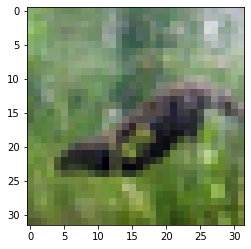

In [4]:
### 반복실행
idx = random.randint(0,49999)
print(f"이미지 인덱스 : {y_train[idx]}")
plt.imshow(x_train[idx])
plt.show()

In [5]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

## Validation set 생성

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# splitting data into training and test sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2023)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 1), (10000, 32, 32, 3), (10000, 1))

## X : Min-Max Scaling

In [8]:
x_min, x_max = x_train.min(), x_train.max()

x_train = (x_train - x_min)/(x_max-x_min)
x_val = (x_val - x_min)/(x_max-x_min)
x_test = (x_test - x_min)/(x_max-x_min)

## Y : One-Hot Encoding

In [25]:
import numpy as np
class_n = len(np.unique(y_train))

from tensorflow.keras.utils import to_categorical


y_train =to_categorical(y_train, class_n)
y_val =to_categorical(y_val, class_n)
y_test = to_categorical(y_test, class_n)

x_train.shape, y_train.shape

((40000, 32, 32, 3), (40000, 100))

## **Data Augmentation**

In [9]:
!mkdir /content/temp/

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 제너레이터를 선언함!  제너레이팅 규칙과 함께!
trainIDG = ImageDataGenerator(rotation_range=30,      # 0~20 사이로 랜덤하게 이미지 각도를 비틈
                              zca_whitening=True,     # apply ZCA whitening
                              zoom_range = 0.1,       # 랜덤하게 확대
                              width_shift_range=0.1,  # 너비가 이동
                              height_shift_range=0.1, # 높이가 이동
                              horizontal_flip=True,   #  
                              vertical_flip=True)     # 

# 어떤 데이터를 바탕으로 제너레이팅 할 것인지, 미리 알려줌!
# 옵션에 따라 필요할 수도 있고 그렇지 않을 수 있다.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [11]:
valIDG = ImageDataGenerator()
# trainIDG.fit(x_train)

# 학습 할 때마다, '실시간'으로 데이터를 생성하여 학습에 활용하고, 버리고를 반복할 준비!
flow_trainIDG = trainIDG.flow(x_train, y_train, batch_size=128, save_to_dir = '/content/temp/')
flow_valIDG = valIDG.flow(x_val, y_val, batch_size = 128)

## Keras로 자유롭게 CNN 모델링

1. [이 구조를 미니 버전으로 활용해봐도 좋다](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
2. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.

In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers import Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential

## Early Stopping을 이용한 학습

- 5
 epoch 연속으로 val_loss가 개선되지 않았으면 멈추는 얼리스토핑 모델을 만드시오.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', # 관측대상 : 무엇을 보고 얼리스토핑을 할지
patience = 5,
min_delta = 0,
verbose = 1,
restore_best_weights =True)

In [19]:
model = Sequential([Input(shape=(32,32,3)),
                    Conv2D(
                    filters = 32,
                    kernel_size= (3,3),
                    padding='same',
                    strides= (1,1),
                    activation='relu'),

                    Conv2D(
                    filters = 32,
                    kernel_size= (3,3),
                    padding='same',
                    strides= (1,1),
                    activation='relu'),
                    MaxPool2D(pool_size = (2,2),
                              strides = (2,2)),
                    BatchNormalization(),
                    Dropout(0.25),

                    Conv2D(
                    filters = 64,
                    kernel_size= (3,3),
                    padding='same',
                    strides= (1,1),
                    activation='relu'),

                    Conv2D(
                    filters = 64,
                    kernel_size= (3,3),
                    padding='same',
                    strides= (1,1),
                    activation='relu'),
                    MaxPool2D(pool_size = (2,2),
                              strides = (2,2)),
                    BatchNormalization(),
                    Dropout(0.25),

                    Flatten(),
                    Dense(100, activation= 'softmax')
])

In [20]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        1

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', # 관측대상 : 무엇을 보고 얼리스토핑을 할지
patience = 5,
min_delta = 0,
verbose = 1,
restore_best_weights =True)

In [30]:
flow_trainIDG = trainIDG.flow(x_train, y_train, batch_size=32)

model.fit(flow_trainIDG, validation_data = flow_trainIDG, epochs = 1000, verbose=1, callbacks = [es])

Epoch 1/1000
1250/1250 [==============================] - 52s 42ms/step - loss: 194537.0312 - accuracy: 0.0000e+00 - val_loss: 145688.4375 - val_accuracy: 0.0000e+00
Epoch 2/1000
1250/1250 [==============================] - 70s 56ms/step - loss: 224035.8906 - accuracy: 0.0000e+00 - val_loss: 175863.2031 - val_accuracy: 0.0000e+00
Epoch 3/1000
1250/1250 [==============================] - 52s 41ms/step - loss: 252962.1250 - accuracy: 0.0000e+00 - val_loss: 182868.5781 - val_accuracy: 0.0000e+00
Epoch 4/1000
1250/1250 [==============================] - 71s 56ms/step - loss: 280246.9062 - accuracy: 0.0000e+00 - val_loss: 202628.5000 - val_accuracy: 0.0000e+00
Epoch 5/1000
1250/1250 [==============================] - 52s 41ms/step - loss: 307005.9688 - accuracy: 0.0000e+00 - val_loss: 223710.2656 - val_accuracy: 0.0000e+00
Epoch 6/1000
1250/1250 [==============================] - 70s 56ms/step - loss: 333782.4375 - accuracy: 0.0000e+00 - val_loss: 242504.0938 - val_accuracy: 0.0000e+00
Epoc

* 예측값 생성 및 구조 변경

In [ ]:
import os



In [31]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [24]:
y_pred[0].shape

(100,)

In [36]:
single_y_pred

array([52, 52, 52, ..., 52, 52, 52])

In [32]:
single_y_pred = y_pred.argmax(axis=1)
single_y_test = y_test.argmax(axis=1)

* 성능 평가

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
test_acc = accuracy_score(single_y_test, single_y_pred)

In [35]:
print(f'테스트셋 정확도 : {test_acc*100}%')

테스트셋 정확도 : 0.0%


## 이미지 시각화

In [ ]:
import random as rd

In [ ]:
np.floor(y_pred[rand_n]*100)

* 반복 실행하여 확인해봅시다.

In [ ]:
rand_n = rd.randrange(0, single_y_test.shape[0])

print(f'id : {rand_n}')
print(f'실제 카테고리 인덱스 : {single_y_test[rand_n]}')
print(f'모델의 카테고리 인덱스 예측 : {single_y_pred[rand_n]}')

if single_y_test[rand_n] == single_y_pred[rand_n] :
    print('정답')
else :
    print('오답')

print('======================================')
print(f'모델의 카테고리별 확률 : \n{np.floor(y_pred[rand_n]*100)}%')
print('======================================')

plt.figure(figsize=(5,5))
plt.title(f'Category Index {single_y_test[rand_n]}')
plt.imshow(x_test[rand_n].reshape(32,32,3))
plt.show()

* 틀린 것만 확인해봅시다.

In [ ]:
y_tf = single_y_pred==single_y_test
false_idx = np.where(y_tf==False)[0]
false_len = len(false_idx)

idx = false_idx[rd.randrange(0, false_len)]

print(f'id : {idx}')
print(f'실제 카테고리 인덱스 : {single_y_test[idx]}')
print(f'모델의 카테고리 인덱스 예측 : {single_y_pred[idx]}')

if single_y_test[idx] == single_y_pred[idx] :
    print('정답')
else :
    print('오답')

print('======================================')
print(f'모델의 카테고리별 확률 : \n{np.floor(y_pred[rand_n]*100)}%')
print('======================================')

plt.figure(figsize=(5,5))
plt.title(f'Category Index {single_y_test[idx]}')
plt.imshow(x_test[idx].reshape(32,32,3))
plt.show()